# Intro to Machine Learning: **scikit-learn**
CFAO Fall Retreat 2020 Hackathon

This notebook gives an introduction to the Machine Learning (ML) features available in the *scikit-learn* (sklearn) package. We will use a table of data collected from Galactic Center observations (NIRC2 image & header data, weather observations, seeing measurements, and AO telemetry) in order to demonstrate the use cases of the package. The data for this tutorial is available for download in [this google folder](https://drive.google.com/drive/folders/1z8ShdhZyKj7FPCPrM93VPxnfIpLPVKcR) -> *keck_ao_metadata.zip*. Please unzip this file and edit the relevant paths in the preamble below to get started. This is by no means a comprehensive list of everything the sklearn package can do: more info can be found in the [documentation](https://scikit-learn.org/stable/) and in [this tutorial](https://www.kaggle.com/learn/intro-to-machine-learning) by [Kaggle](https://www.kaggle.com/). For these examples, you will need to have the [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/) packages installed in addition to the [sklearn](https://scikit-learn.org/stable/) package itself. A description of the data used can be found in the table below:
![image](https://scontent-atl3-1.xx.fbcdn.net/v/t1.0-9/123168793_10217839290198500_2309566273105995815_o.jpg?_nc_cat=107&ccb=2&_nc_sid=730e14&_nc_ohc=FLIy1AZZhnMAX_eK5go&_nc_ht=scontent-atl3-1.xx&oh=d052202cc31937173dd813819401fdc1&oe=5FC05045)

In [1]:
# Preamble
import numpy as np
import pandas as pd

# Plots and images
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     ParameterSampler, RandomizedSearchCV)

from CFAOutils import clean_data, print_score, plot_score

# Data location (replace with your own path)
data_dir = "./"
data_file = data_dir+"keck_ao_metadata.dat"
# Columns we will use for feature data (feel free to add/delete)
features = ['airmass', 'az', 'mass', 'dimm', 'wind_speed', 
               'wind_direction', 'temperature', 'relative_humidity', 'pressure',
                      'masspro', 'masspro_half', 'masspro_1', 'masspro_2',
                      'masspro_4', 'masspro_8', 'masspro_16']
# Columns we will use for target data
targets = ['strehl', 'fwhm']

# Limits for good data
clean_features = {
    'strehl': (0, np.inf),
    'fwhm': (0, 150),
    'wind_direction': (-0.1, np.inf), # include 0
    'lgrmswf': (0, 1500),
}

# time between weather/seeing and primary observation
# Feel free to edit
deltas = { # in minutes
    'mass_mjd': 5,
    'dimm_mjd': 5,
    'masspro_mjd': 5,
    'cfht_mjd': 5,
}

# Select a random seed
random_seed = 42

In [2]:
# Set up plotting
mpl.rcParams['font.size']=14
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

## Section 1: Preprocessing

For simplicity, we will drop all rows with invalid values. For other methods of dealing with missing data, see sklearn's [impute](https://scikit-learn.org/stable/modules/impute.html#impute) module or the [intermediate ML](https://www.kaggle.com/learn/intermediate-machine-learning) tutorial from Kaggle. We will also limit our weather and seeing observations to those taken within 5 minutes of the primary NIRC2 image.

In [3]:
# Import and clean data
data = pd.read_csv(data_file)
data.columns = [x.lower() for x in data.columns]
# ML data sample
data = data[features+targets]
data = clean_data(data, dropna=True, feature_limits=clean_features, deltas=deltas)
print("Columns:", list(data.columns))
print("Data dimensions:", data.shape)
data.head()

Columns: ['index', 'airmass', 'az', 'mass', 'dimm', 'wind_speed', 'wind_direction', 'temperature', 'relative_humidity', 'pressure', 'masspro', 'masspro_half', 'masspro_1', 'masspro_2', 'masspro_4', 'masspro_8', 'masspro_16', 'strehl', 'fwhm']
Data dimensions: (2945, 19)


,index,airmass,az,mass,dimm,wind_speed,wind_direction,temperature,relative_humidity,pressure,masspro,masspro_half,masspro_1,masspro_2,masspro_4,masspro_8,masspro_16,strehl,fwhm
0,1643,1.55908,166.16518,0.06,0.40,1.0,119.0,3.52,48.0,618.2,0.16,1.140000e-14,2.590000e-15,5.520000e-22,2.040000e-15,4.950000e-16,1.400000e-14,0.331,59.09
1,1644,1.55759,166.39213,0.06,0.40,1.0,119.0,3.52,48.0,618.2,0.16,1.140000e-14,2.590000e-15,5.520000e-22,2.040000e-15,4.950000e-16,1.400000e-14,0.312,61.04
2,1645,1.55611,166.62168,0.06,0.45,1.0,119.0,3.50,47.0,618.2,0.16,1.140000e-14,2.590000e-15,5.520000e-22,2.040000e-15,4.950000e-16,1.400000e-14,0.316,57.67
3,1646,1.55465,166.85421,0.06,0.45,2.0,119.0,3.47,47.0,618.3,0.16,1.140000e-14,2.590000e-15,5.520000e-22,2.040000e-15,4.950000e-16,1.400000e-14,0.238,73.30
4,1647,1.55310,167.10523,0.06,0.42,1.0,120.0,3.45,50.0,618.3,0.16,1.140000e-14,2.590000e-15,5.520000e-22,2.040000e-15,4.950000e-16,1.400000e-14,0.269,65.81


### Choose feature and target data
**Target data** is the data you are trying to predict with your machine learning algorithm. It can be binary (0,1), categorical ('apple', 'orange', 'lemon'), or continuous ([0,1], (0.5, 257.3], etc.), but different algorithms may need to be used for each type of target. In our case, we will be predicting image quality, so our targets are the strehl ratio and FWHM of the final NIRC2 images.

**Feature data** is any data you will use to predict your targets, so it *must* match the data you will have available in the standard use case of the algorithm. For example, we will not have access to any of the NIRC2 image or header data before an image quality prediction is made, nor will we have the AO telemetry, so these data cannot be used in our predictions.

In [4]:
target = targets[0] # We'll use fwhm as our target for now (feel free to change)
X = data[features]
y = data[target]

### Validation
Before we can dive into our ML algorithms, we must first decide how we will evaluate their success. One way to do this is with a *test set*, or data that we hold out of our algorithm's training process in order to test it later on. Another strategy is *k-fold cross-validation*, in which the data is split *n* times, and the performance on the left-out portion is averaged to get the final error. We will use a single test set in this example. It is ***very important*** that no preprocessing or other ML functions are used on the test set, or on the full dataset with the test set included. This would bias the process by indirectly including information about the test set in the training set.

Some metrics for scoring ML algorithms are listed below:  
- The **Mean Absolute Error (MAE)**: $\frac{1}{N}\sum_{i=1}^N |y_{pred}-y_{true}|$, where N is the number of data points.  
- The **R-score**, aka the **coefficient of determination**: $R^2 = 1 - \frac{u}{v}$, where $u = \sum_{i=1}^N |y_{true}-y_{pred}|^2$ (residual sum of squares), and $v = \sum_{i=1}^N |y_{true}-\bar{y}_{true}|^2$ (total sum of squares). 1.0 is the highest R-score possible, but it can be arbitrarily negative. Most sklearn algorithms have a built-in scoring method for this.

##### Scaling the data
In order to get the best performance with some algorithms, the data must be scaled to zero mean and $\sigma=1$. This is due to a process called [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent#:~:text=Gradient%20descent%20is%20a%20first,function%20at%20the%20current%20point.). To keep the test set from leaking into the training set, we must use the same transform on both.

In [5]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
# Scale data
scaler = StandardScaler().fit(X_train) # training set ONLY
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test) # both sets

### Principal Component Analysis (optional)
PCA is a way to reduce the **dimensionality** of your data. It decomposes the feature matrix into N orthoganal components, sorted by how much information each component contains from the original features, the **explained variance**. As the target matrix is not involved, this is generally regarded as a preprocessing step rather than an ML algorithm in its own right. The components are given in descending order of their **explained variance ratios**, based on what percentage of the original feature data can be reconstructed from that component alone. For example, if you have 5 components whose explained variance ratios sum to 0.9, you would be able to recover 90% of your original dataset from just those components. For this reason, a principal component analysis is a good way to eliminate unneccessary features - i.e. the ones with very small explained variance ratios. PCA can also enforce **feature independence**, which is a prerequisite for many ML models. A visual example with a 2-dimensional dataset is shown below:

![image](https://miro.medium.com/max/462/1*QALwLkPJG45E7_DsOccdaw.png)

**Note:** again, we must do the same PCA transform on both the training and the test sets, and that transform must be calculated only based on the training data.

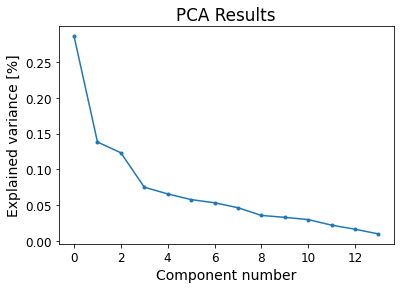

In [6]:
tol = 0.01 # tolerance: we want to keep 99% of our original data
pca = PCA(1-tol)
# Fit to training set
pca.fit(X_train)
# Transform train and test set
X_train, X_test = pca.transform(X_train), pca.transform(X_test)

# Plot explained variance
plt.plot(pca.explained_variance_ratio_, '.-')
plt.xlabel("Component number")
plt.ylabel("Explained variance [%]")
plt.title("PCA Results")
plt.show()

## Section 2: Algorithms
More details on the following algorithms can be found on the sklearn [modules](https://scikit-learn.org/stable/modules/classes.html) page.

### [Ridge Regression](https://www.statisticshowto.com/ridge-regression/)
- Modifies [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to be less prone to overfitting
- Fits an n-dimensional hyperplane to data with n-features
- Takes *regularization* parameter(s) to keep the coefficients (slopes) of each feature to within a given range
- A less-advanced version of [Support Vector Regression](https://scikit-learn.org/stable/modules/svm.html#svm)

Strehl MAE: 0.045 , R-score: 0.511


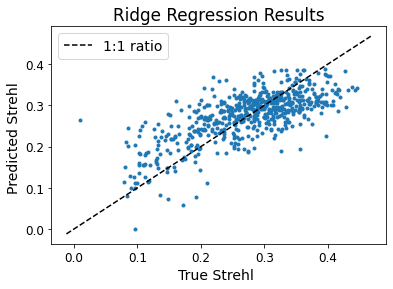

In [7]:
alpha = 2 # Regularization strength: higher = more regularization
ridge = Ridge(alpha=alpha, random_state=random_seed)
# Train the model
ridge.fit(X_train, y_train)
# Check performance on the test set
y_pred = ridge.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = ridge.score(X_test, y_test)
# Print results
print_score(target, mae, r2)
plot_score('Ridge Regression', target, y_test, y_pred)

### [Random Forest Regression](https://medium.com/@aaaanchakure/random-forest-and-its-implementation-71824ced454f)
- Averages the results from *N* decision trees to get the final prediction
- Fairly robust to overfitting
- Can model nonlinear relationships between features
- Can take binary, categorical, and continuous features as-is

Strehl MAE: 0.032 , R-score: 0.725


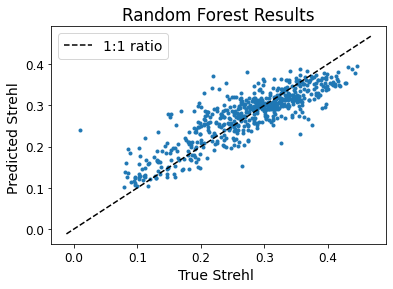

In [8]:
rf = RandomForestRegressor(n_estimators=200, criterion='mae', max_depth=10, max_features=0.8,
                           random_state=random_seed)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
r2 = rf.score(X_test, y_test)
print_score(target, mae, r2)
plot_score('Random Forest', target, y_test, y_pred)

### [Multi-Layer Perceptron Regression](https://en.wikipedia.org/wiki/Multilayer_perceptron) (Neural Network)
- Can fit almost any relationships in feature data
- Very easy to overfit data if there are not enough samples
- This is a more complicated model, so it's hard to tell *how* it comes to its solution once it's reached

Strehl MAE: 0.030 , R-score: 0.778


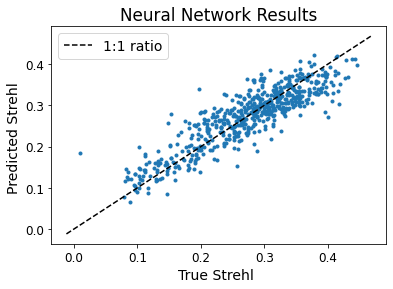

In [9]:
hls = (40, 40) if target=='fwhm' else (45, 45) # Works best for this data, feel free to change
lr = 0.2 if target=='fwhm' else 0.01
mlp = MLPRegressor(hidden_layer_sizes=hls, max_iter=300, learning_rate='adaptive',
                   learning_rate_init=lr, random_state=random_seed)
mlp.fit(X_test, y_test)
y_pred = mlp.predict(X_test)

mae = mean_absolute_error(y_pred, y_test)
r2 = mlp.score(X_test, y_test)
print_score(target, mae, r2)
plot_score('Neural Network', target, y_test, y_pred)

## Section 3: Model Selection
These methods allow for the tuning of **hyperparameters** in ML algorithms. Hyperparameters refer to aspects of the *model* itself, rather than the data (i.e. *n_estimators* or *hidden_layer_sizes* in the examples above). In order to find the best hyperparameters for a given algorithm, we have to search the ones available. **Grid Search** tests a range of different parameters in a grid, while **Randomized Search** takes N samples from the given parameter ranges (or distributions). For more on hyperparameter optimization methods, see [the Wikipedia page](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

<img src="https://miro.medium.com/max/1004/0*yDmmJmvRowl0cSN8.png" alt="Image" style="width: 600px;"/>

### Grid Search
- Takes a grid of parameters and checks every combination
- Uses k-fold cross-validation (default k=5), so results are robust
- K-fold cross-validation means it runs *really* slowly if you have a lot of parameters

Let's try to find the best hyperparameters for one of our algorithms:

In [10]:
# Select parameters
params = {
    'hidden_layer_sizes': [(i,i) for i in range(10, 60, 5)],
    'learning_rate': ['adaptive'],
    'learning_rate_init': list(np.arange(0.1, 0.5, 0.1))+list(np.arange(0.01, 0.05, 0.01)),
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [200, 300, 400],
}

Strehl MAE: 0.032 , R-score: 0.710


/opt/anaconda3/envs/astroconda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


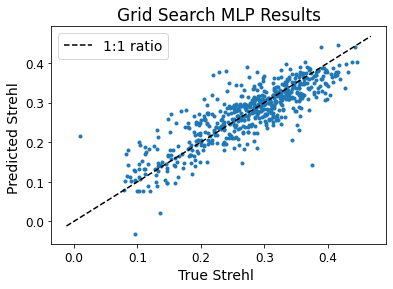

{'hidden_layer_sizes': (40, 40),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'max_iter': 200,
 'solver': 'lbfgs'}

In [11]:
# Initialize ML algorithm
clf = MLPRegressor(random_state=random_seed)
# Start grid search with parameters
gridsearch = GridSearchCV(clf, param_grid=params, n_jobs=-2,
                          cv=5)
# Train model
gridsearch.fit(X_train, y_train) # This will take a minute or two
y_pred = gridsearch.predict(X_test)
# Get results
mae = mean_absolute_error(y_pred, y_test)
r2 = gridsearch.score(X_test, y_test)
print_score(target, mae, r2)
plot_score('Grid Search MLP', target, y_test, y_pred)
gridsearch.best_params_

### Randomized Search
- Takes either lists of parameter values, like the ones in Grid Search, or estimators to sample from such as the ones in the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module.
- Randomly takes *n_iter* samples from the provided values/estimators and uses k-fold cross-validation (default k=5) to test the results.

In [12]:
def hls_generator(mean, std, nsamp=20):
    ''' Generates hidden layer sizes from a normal distribution '''
    np.random.seed(random_seed)
    nums = np.random.normal(mean, std, nsamp*2).astype(int)
    hls = [(nums[i], nums[i+1]) for i in range(len(nums)-1)]
    return hls

In [13]:
hls = hls_generator(mean=40, std=5)
lr_init = list(np.arange(0.1, 0.5, 0.1)) if target=='fwhm' else list(np.arange(0.01, 0.05, 0.01))

# Select parameters
params = {
    'hidden_layer_sizes': hls,
    'learning_rate': ['adaptive'],
    'learning_rate_init': lr_init,
#     'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [200, 300, 400],
}

Strehl MAE: 0.035 , R-score: 0.700


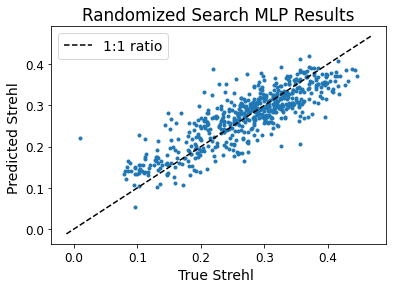

{'max_iter': 400,
 'learning_rate_init': 0.02,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (33, 40)}

In [14]:
clf = MLPRegressor(random_state=random_seed)
r_search = RandomizedSearchCV(clf, params, n_iter=100, random_state=random_seed)

r_search.fit(X_train, y_train)
y_pred = r_search.predict(X_test)
# Get results
mae = mean_absolute_error(y_pred, y_test)
r2 = r_search.score(X_test, y_test)
print_score(target, mae, r2)
plot_score('Randomized Search MLP', target, y_test, y_pred)
r_search.best_params_